# Popularity Prediction Project

Team:
1. Renee Dhanaraj
2. Aditi Verma
3. Chris Park
4. Aryan Ahuja

In [ ]:
# sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score, roc_auc_score, r2_score, mean_absolute_error, mean_squared_error, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# data manipulation imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import MinMaxScaler
import random
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV



## Importing dataset

In [ ]:
original_dataset_df = pd.read_csv('dataset/dataset.csv')
original_dataset_df.head()

## Data Cleaning

In [ ]:
# creating a copy to clean to avoid contamination of original data
df = original_dataset_df.copy()

In [ ]:
# information about the dataset, such as number of entries, column names, non-null counts, and data types
df.info()

In [ ]:
# getting the summary statistics of the dataset (of numerical features)
df.describe()

In [ ]:
# checking for missing values in each column
df.isnull().sum()

In [ ]:
# dropping all the rows with any missing/null values since there are very few
df = df.dropna()

# IF WE PLAN TO NOT USE NLP FOR NATURAL LANGUAGE PROCESSING, UNCOMMENT AND DROP TEXT COLUMNS
# df = df.drop(columns=["artists", "album_name", "track_name", "track_genre"])

# making sure the "explicit" column is of type integer and not boolean
df["explicit"] = df["explicit"].astype(int)

#### Sanity Checks

In [ ]:
# sanity checks for the important numeric columns
print("Popularity range:", df["popularity"].min(), "to", df["popularity"].max())
print("Duration range (ms):", df["duration_ms"].min(), "to", df["duration_ms"].max())
print("Tempo range:", df["tempo"].min(), "to", df["tempo"].max())
print("Loudness range:", df["loudness"].min(), "to", df["loudness"].max())

# duplicate check
duplicates_mask = df.duplicated(subset=["artists", "album_name", "track_name","track_id"])
print("Number of duplicate entries based on artists, album_name, track_name:", duplicates_mask.sum())
# print(len(df))

Popularity range: 0 to 100
Duration range (ms): 8586 to 5237295
Tempo range: 0.0 to 243.372
Loudness range: -49.531 to 4.532
Number of duplicate entries based on artists, album_name, track_name: 24259


In [ ]:
# sanity checks for categorical columns
print("Explicit values:", df["explicit"].value_counts())
print("\nMode values:", df["mode"].value_counts())
print("\nTime signature values:", df["time_signature"].value_counts())
print("\nKey values:", df["key"].value_counts().sort_index())



In [10]:
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,0,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,0,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,0,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,0,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,0,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [11]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 113999 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        113999 non-null  int64  
 1   track_id          113999 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        113999 non-null  int64  
 6   duration_ms       113999 non-null  int64  
 7   explicit          113999 non-null  int64  
 8   danceability      113999 non-null  float64
 9   energy            113999 non-null  float64
 10  key               113999 non-null  int64  
 11  loudness          113999 non-null  float64
 12  mode              113999 non-null  int64  
 13  speechiness       113999 non-null  float64
 14  acousticness      113999 non-null  float64
 15  instrumentalness  113999 non-null  float64
 16  liveness          113999 

Unnamed: 0          0
track_id            0
artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

## Exploratory Data Analysis (EDA)

#### Looking at overall distribution

In [12]:
# checking for outliers in numerical columns using box plots
numerical_columns = ["popularity", "duration_ms", "tempo", "loudness", "danceability", "energy", "speechiness", "acousticness", "instrumentalness", "liveness", "valence"]
# for col in numerical_columns:
#     plt.figure(figsize=(8, 4))
#     plt.boxplot(df[col], vert=False)
#     plt.title(f'Box plot of {col}')
#     plt.xlabel(col)
#     plt.show()

# We can see that some features are skewer, but if we train models like XGBoost, for ensemble methods, we need not do any transformations
# There are some outliers as well, but we still need to keep them since they are real songs and removing them would lead to loss of information
# Hence, we will not be doing any outlier removal or transformations for skewness at this point

# If required for training (linear models or nerual networks), we can always do log transformations or apply standardization/normalization later

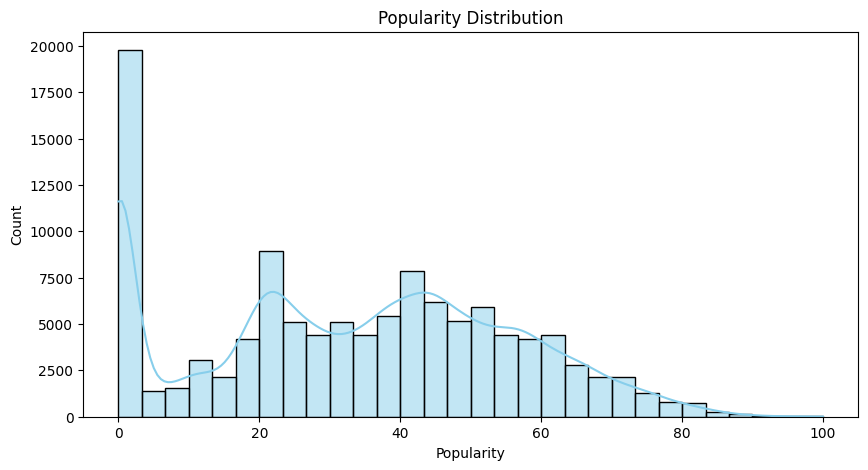

In [13]:
plt.figure(figsize=(10, 5))
sns.histplot(df['popularity'], bins=30, kde=True, color='skyblue')
plt.title('Popularity Distribution')
plt.xlabel('Popularity')
plt.ylabel('Count')
plt.show()

#### Heat maps to look at relationships

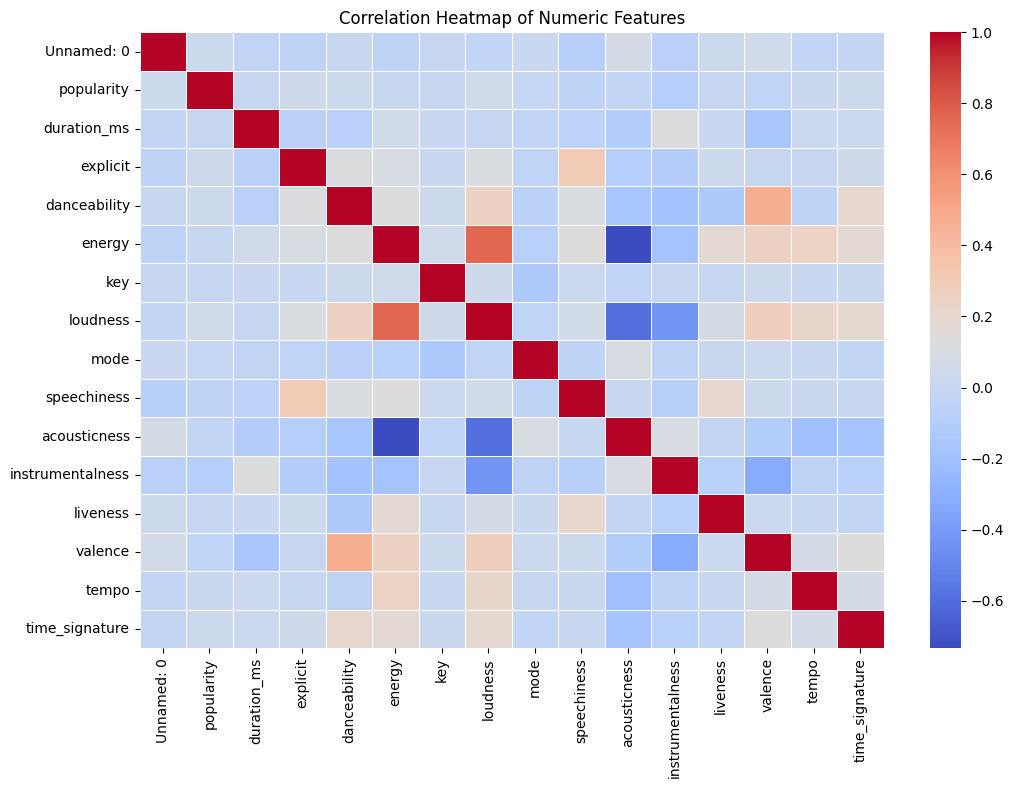

' OBSERVATIONS:\nGenerally a lot more negative corrolation than positive ones.\n\nSong Type\n    Negative corrolation: \n        energy + acousticness\n        loudness + acousticness\n        loudness + instrumentalness\n        valence + instrumentalness\n\n    Positive corrolation:\n        loudness + energy\n        loudness + danceability\n        danceability + valence\n        energy + valence\n        speechiness + explicit\n\nPopularity\n    Negative corrolation:\n        popularity + instrumentalness\n        popularity + duration_ms\n\n    No positive corrolation :((\n'

In [14]:
#attempt visualizing a headmap 
#use only numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

#compute correlation matrix
corr = numeric_df.corr()

#plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

""" OBSERVATIONS:
Generally a lot more negative corrolation than positive ones.

Song Type
    Negative corrolation: 
        energy + acousticness
        loudness + acousticness
        loudness + instrumentalness
        valence + instrumentalness
    
    Positive corrolation:
        loudness + energy
        loudness + danceability
        danceability + valence
        energy + valence
        speechiness + explicit

Popularity
    Negative corrolation:
        popularity + instrumentalness
        popularity + duration_ms

    No positive corrolation :((
"""

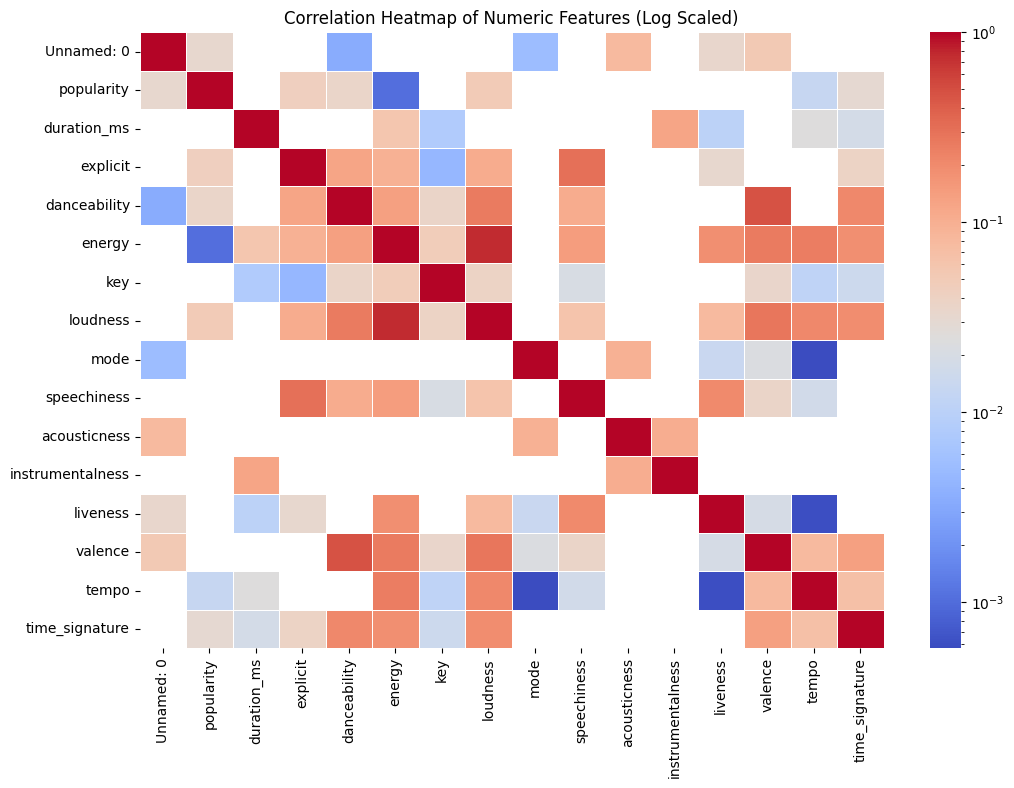

' OBSERVATIONS:\nGenerally a lot more positive corrolations\n\nPopularity\n    Negative corrolation:\n        energy\n        tempo\n\n    Positive corrolation:\n        explicit\n        danceability\n        loudness\n        time_signature\n\n'

In [15]:
# Try normalizing using log_scale to address highly skewed datasets
plt.figure(figsize=(12, 8))
sns.heatmap(corr, norm=mcolors.LogNorm(), cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features (Log Scaled)")
plt.show()

""" OBSERVATIONS:
Generally a lot more positive corrolations

Popularity
    Negative corrolation:
        energy
        tempo

    Positive corrolation:
        explicit
        danceability
        loudness
        time_signature
        
"""
# dig deeper into the significant corrolations

#### More EDA that is related to popularity

In [16]:
plt.scatter(df["popularity"], df["duration_ms"])
plt.xlabel("Popularity")
plt.ylabel("Duration")
plt.title("Popularity vs duration")
plt.show()

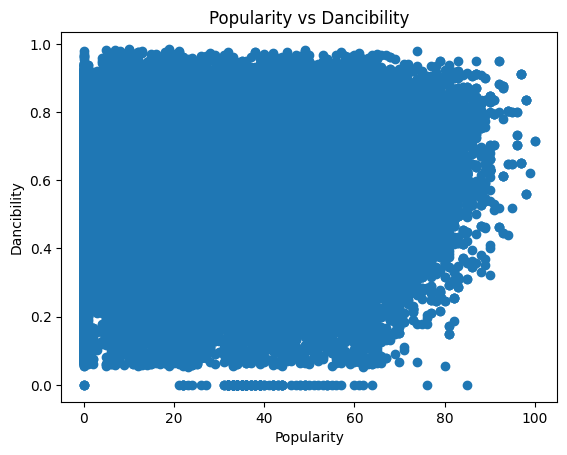

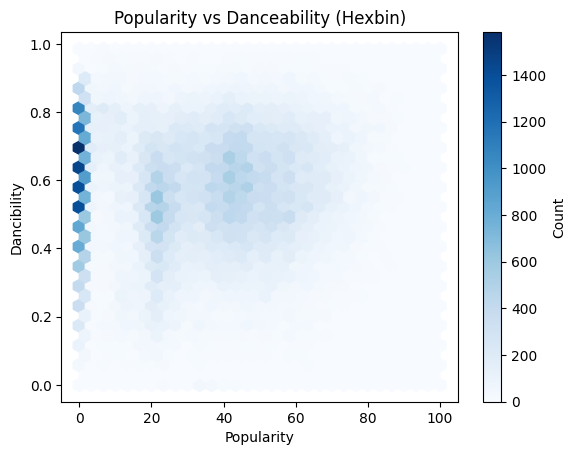

In [17]:
plt.scatter(df["popularity"], df["danceability"])
plt.xlabel("Popularity")
plt.ylabel("Dancibility")
plt.title("Popularity vs Dancibility")
plt.show()

plt.hexbin(df["popularity"], df["danceability"], gridsize=30, cmap='Blues')
plt.colorbar(label='Count')
plt.xlabel("Popularity")
plt.ylabel("Dancibility")
plt.title("Popularity vs Danceability (Hexbin)")
plt.show()

In [ ]:
plt.scatter(df["popularity"], df["energy"])
plt.xlabel("Popularity")
plt.ylabel("energy")
plt.title("Popularity vs energy")
plt.show()

plt.hexbin(df["popularity"], df["energy"], gridsize=30, cmap='Blues')
plt.colorbar(label='Count')
plt.xlabel("Popularity")
plt.ylabel("Dancibility")
plt.title("Popularity vs Energy (Hexbin)")
plt.show()

#### 2 strong relationship features vs popularity

In [ ]:
#Energy and loudness
df["energy_q"] = pd.qcut(df["energy"], 10)
df["loudness_q"] = pd.qcut(df["loudness"], 10)
pivot = df.pivot_table(values="popularity", index="loudness_q", columns="energy_q", aggfunc="mean")
sns.heatmap(pivot, cmap="viridis")

In [ ]:
# Dancability and varience
df["danceability_q"] = pd.qcut(df["danceability"], 10)
df["valence_q"] = pd.qcut(df["valence"], 10)
pivot = df.pivot_table(values="popularity", index="danceability_q", columns="valence_q", aggfunc="mean")
sns.heatmap(pivot, cmap="viridis")

#### Normalize numerical columns

In [ ]:
#normalize numerical columns
scaler = MinMaxScaler()
df_norm = df.copy()
numerical_columns.pop(0)
df_norm[numerical_columns] = scaler.fit_transform(df[numerical_columns])
plt.figure(figsize=(14, 6))

df_melted = df_norm[numerical_columns].melt(var_name="Feature", value_name="Normalized")
sns.boxplot(
    data=df_melted,
    x="Feature",
    y="Normalized",
    hue="Feature",       
    palette="Set2",
    dodge=False         
)
plt.xticks(rotation=45, ha="right")
plt.title("Normalized Boxplots for All Numerical Features")
plt.ylabel("Normalized Value (0–1)")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()


print(df_norm["popularity"].value_counts())

## Feature Engineering & Model Training

### Feature Engineering / Model Training / Model Eval for Aryan's Logistic Regression Model and Neural Network Model

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score, balanced_accuracy_score, confusion_matrix
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from typing import List

import pandas as pd
import numpy as np

import torch
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# helper functions to preprocess the data
def get_X_y(df: pd.DataFrame, 
            target_columns: List[str]):
    """
    Splits the dataframe into features and target
    """
    X = df.drop(columns=target_columns)
    y = df[target_columns]
    return X, y


def make_popularity_classes(popularity_series: pd.Series):
    """
    Converts a popularity series into discrete classes
    """
    return (popularity_series >= 50).astype(int)


def encode_data(X_train: pd.DataFrame,
                X_val: pd.DataFrame,
                X_test: pd.DataFrame,
                numerical_columns: List[str],
                feature_encode_cols: List[str],
                onehot_encode_cols: List[str]):
    """
    Encodes the data using frequency encoding, one hot encoding and standard scaling.
    This function acts as a pipeline to fit and transform the data so you don't have to call fit and transform separately.
    """
    # we need to make sure to fit the different encoders on the training data only
    # this avoids data leakage from test and validation sets
    frequency_map, ohe, scaler = _fit_encoders(
        X_train, numerical_columns, feature_encode_cols, onehot_encode_cols
    )

    # once fitted, we can transform the train, validation, and test sets
    X_train_encoded = _transform_features(
        X_train, 
        numerical_columns, feature_encode_cols, onehot_encode_cols,
        frequency_map, ohe, scaler
    )
    X_val_encoded = _transform_features(
        X_val,
        numerical_columns, feature_encode_cols, onehot_encode_cols,
        frequency_map, ohe, scaler
    )
    X_test_encoded = _transform_features(
        X_test, 
        numerical_columns, feature_encode_cols, onehot_encode_cols,
        frequency_map, ohe, scaler
    )

    return X_train_encoded, X_val_encoded, X_test_encoded, frequency_map, ohe, scaler


def _fit_encoders(X_train: pd.DataFrame,
                 numerical_columns: List[str],
                 feature_encode_cols: List[str],
                 onehot_encode_cols: List[str]):
    """
    PRIVATE HELPER FUNCTION

    Fits the encoders for numerical and categorical features
    """
    # frequency mapping for frequency encoding categorical features
    frequency_map = {}
    for col in feature_encode_cols:
        frquency = X_train[col].value_counts(normalize=True) # get frequency of each category as proportion
        frequency_map[col] = frquency.to_dict()

    # one hot encoding the necessary columns
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    ohe.fit(X_train[onehot_encode_cols])

    # standard scaling the numerical columns for neural networks or linear models
    scaler = StandardScaler()
    scaler.fit(X_train[numerical_columns])

    return frequency_map, ohe, scaler


def _transform_features(X: pd.DataFrame,
                       numerical_columns: List[str],
                       feature_encode_cols: List[str],
                       onehot_encode_cols: List[str],
                       frequency_map: dict,
                       ohe: OneHotEncoder,
                       scaler: StandardScaler):
    """
    PRIVATE HELPER FUNCTION

    Transforms the features using the fitted encoders
    """
    # scaling numerical columns
    X_std_scaled = scaler.transform(X[numerical_columns])

    # transoforming frequency encoded columns
    frequency_features = []
    for col in feature_encode_cols:
        frequency_map_col = frequency_map[col]
        encoded_col = X[col].map(frequency_map_col).fillna(0).values.reshape(-1, 1)
        frequency_features.append(encoded_col)
    X_frequency_encoded = np.hstack(frequency_features) if frequency_features else np.empty((X.shape[0], 0))

    # transforming one hot encoded columns
    X_onehot_encoded = ohe.transform(X[onehot_encode_cols]) if onehot_encode_cols else np.empty((X.shape[0], 0))

    # combining all features together
    x = np.hstack([X_std_scaled, X_frequency_encoded, X_onehot_encoded])
    return x


def compute_classification_metrics(y_true, y_pred):
    """
    Computes precision, recall and balanced accuracy scores
    """
    avg = "binary"
    precision = precision_score(y_true, y_pred, average=avg, zero_division=0)
    recall = recall_score(y_true, y_pred, average=avg, zero_division=0)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    return precision, recall, bal_acc

In [ ]:
# will encode Artist name: Feature encoding
# will encode Track genre: One hot encoding
# will drop Album/track names
# rest are numeric columns
cols_to_drop = ["album_name", "track_name"]
feature_encode_cols = ["artists"]
onehot_encode_cols = ["track_genre"]
numerical_columns = [
    "duration_ms", "explicit", "danceability", "energy", "key",
    "loudness", "mode", "speechiness", "acousticness", "instrumentalness",
    "liveness", "valence", "tempo", "time_signature",
]

In [ ]:
"""
PROCESSING DATA BEFORE MODEL TRAINING

1. Get X and y datasets
2. Transform popularity into classes
3. Split into train, validation, and test sets
4. Encode and scale the data (look at helper functions above)
"""

# getting X and y datasets
X, y = get_X_y(df, target_columns="popularity")

# transforming popularity into classes
y = make_popularity_classes(y)

# splitting into train test splits
x_train_full, x_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# further split train into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.1765, stratify=y_train_full, random_state=42
)




"""
UNDERSAMPLING THE MAJORITY CLASS TO BALANCE THE DATASET

uncomment the below code block to perform undersampling of the majority class

Either do this or in the model training phase, use class weights in cost function to balance the dataset
"""
# train_df = x_train.copy()
# train_df["target"] = y_train.values

# # split by class
# df_majority = train_df[train_df["target"] == 0]
# df_minority = train_df[train_df["target"] == 1]

# print("Before undersampling:")
# print("  majority (0):", len(df_majority))
# print("  minority (1):", len(df_minority))

# # downsample majority class
# keep_factor = 0.5
# n_majority_keep = int(len(df_majority) * keep_factor)

# df_majority_down = df_majority.sample(
#     n=n_majority_keep,
#     random_state=42
# )

# # combine and shuffle
# df_down = pd.concat([df_majority_down, df_minority], axis=0)
# df_down = df_down.sample(frac=1.0, random_state=42).reset_index(drop=True)

# # new balanced-ish train X / y
# x_train = df_down.drop(columns=["target"])
# y_train = df_down["target"].values

# print("After undersampling:")
# print("  majority (0):", (y_train == 0).sum())
# print("  minority (1):", (y_train == 1).sum())






# encoding and scaling the data
X_train_encoded, X_val_encoded, X_test_encoded, frequency_map, ohe, scaler = encode_data(
    x_train, x_val, x_test,
    numerical_columns,
    feature_encode_cols,
    onehot_encode_cols
)

In [ ]:
"""
DEFINING A BASE MODEL TO COMPARE MY MODEL AGAINST

BASE MODEL: LOGISTIC REGRESSION
"""
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    r2_score,
    mean_squared_error
)
import numpy as np

model = LogisticRegression(
    max_iter=5000,
    multi_class="auto",
    solver="lbfgs",
    n_jobs=-1,
    random_state=42
)

param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "class_weight": [None, "balanced"]
}

grid_search = GridSearchCV(
    model,
    param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=2
)

# starting grid search
grid_search.fit(X_train_encoded, y_train)

# post training
print("Best hyperparameters:", grid_search.best_params_)
best_lr_model = grid_search.best_estimator_

# validation set evaluation
y_val_pred = best_lr_model.predict(X_val_encoded)

val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average="binary")

# including r2 and rmse for... classification metrics?
val_r2 = r2_score(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print(f"\nValidation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

print("\nValidation Report:")
print(classification_report(y_val, y_val_pred))

In [ ]:
# ensuring reproducibility
torch.manual_seed(42)
np.random.seed(42)

# setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# making a dataset class
class SongDataset(Dataset):
    def __init__(self, X, y):
        self.X = np.asarray(X, dtype=np.float32)
        self.y = np.asarray(y, dtype=np.int64)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        return x, y

# create datasets from your encoded splits
train_ds = SongDataset(X_train_encoded, y_train)
val_ds   = SongDataset(X_val_encoded,   y_val)
test_ds  = SongDataset(X_test_encoded,  y_test)

BATCH_SIZE = 128

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

# defining the model
input_dim  = X_train_encoded.shape[1]
output_dim = 1

class PopularityMLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear_layer11 = nn.Linear(input_dim, 4096)
        self.batch_norm11   = nn.BatchNorm1d(4096)
        self.relu11         = nn.LeakyReLU()

        self.linear_layer12 = nn.Linear(4096, 2048)
        self.batch_norm12   = nn.BatchNorm1d(2048)
        self.relu12         = nn.LeakyReLU()

        self.linear_layer0 = nn.Linear(2048, 1024)
        self.batch_norm0   = nn.BatchNorm1d(1024)
        self.relu0         = nn.LeakyReLU()

        self.linear_layer1 = nn.Linear(1024, 512)
        self.batch_norm1   = nn.BatchNorm1d(512)
        self.relu1         = nn.LeakyReLU()

        self.linear_layer2 = nn.Linear(512, 256)
        self.batch_norm2   = nn.BatchNorm1d(256)
        self.relu2         = nn.LeakyReLU()

        self.linear_layer3 = nn.Linear(256, 128)
        self.batch_norm3   = nn.BatchNorm1d(128)
        self.relu3         = nn.LeakyReLU()

        self.linear_layer4 = nn.Linear(128, 64)
        self.batch_norm4   = nn.BatchNorm1d(64)
        self.relu4         = nn.LeakyReLU()

        self.linear_layer5 = nn.Linear(64, 32)
        self.batch_norm5   = nn.BatchNorm1d(32)
        self.relu5         = nn.LeakyReLU()

        self.out = nn.Linear(64, output_dim)

        self.drop = nn.Dropout(0.3)

    def forward(self, x):

        x = self.linear_layer11(x)
        x = self.batch_norm11(x)
        x = self.relu11(x)
        x = self.drop(x)

        x = self.linear_layer12(x)
        x = self.batch_norm12(x)
        x = self.relu12(x)
        x = self.drop(x)

        x = self.linear_layer0(x)
        x = self.batch_norm0(x)
        x = self.relu0(x)
        x = nn.Dropout(0.4)(x)

        x = self.linear_layer1(x)
        x = self.batch_norm1(x)
        x = self.relu1(x)
        x = nn.Dropout(0.4)(x)

        x = self.linear_layer2(x)
        x = self.batch_norm2(x)
        x = self.relu2(x)
        x = self.drop(x)

        x = self.linear_layer3(x)
        x = self.batch_norm3(x)
        x = self.relu3(x)
        x = self.drop(x)

        x = self.linear_layer4(x)
        x = self.batch_norm4(x)
        x = self.relu4(x)
        x = self.drop(x)

        # x = self.linear_layer5(x)
        # x = self.batch_norm5(x)
        # x = self.relu5(x)

        # output (no activation here for BCEWithLogitsLoss)
        return self.out(x)

model = PopularityMLP().to(device)


pos_ratio = y_train.mean()
neg_ratio = 1 - pos_ratio
pos_weight = torch.tensor(neg_ratio / pos_ratio, device=device)

# loss function, optimizer, scheduler
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-3,
    weight_decay=1e-3,
    betas=(0.9, 0.999)
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-6
)


# epoch runner
def run_epoch(loader, model, criterion, optimizer=None, scheduler=None):
    """
    If optimizer is provided -> training mode
    If optimizer is None -> evaluation mode
    """
    if optimizer is None:
        model.eval()
    else:
        model.train()

    all_labels = []
    all_preds  = []
    running_loss = 0.0
    total_batches = 0

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        if optimizer is not None:
            optimizer.zero_grad()

        with torch.set_grad_enabled(optimizer is not None):
            logits = model(xb)

            yb_float = yb.float().unsqueeze(1)
            loss = criterion(logits, yb_float)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).long().squeeze(1)

        if optimizer is not None:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        running_loss += loss.item()
        total_batches += 1

        all_labels.append(yb.detach().cpu())
        all_preds.append(preds.detach().cpu())

    avg_loss = running_loss / total_batches
    all_labels = torch.cat(all_labels).numpy()
    all_preds  = torch.cat(all_preds).numpy()

    f1 = f1_score(all_labels, all_preds, average="binary")
    acc = accuracy_score(all_labels, all_preds)

    return avg_loss, acc, f1, all_labels, all_preds


# training loop count
EPOCHS = 50

USE_EARLY_STOPPING = True   # toggle this True/False
PATIENCE = 20       # how many epochs with no val loss improvement
MIN_DELTA = 0.0     # minimum improvement in loss to reset patience

best_val_loss = float("inf")
best_state = None
patience_counter = 0

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc, train_f1, _, _ = run_epoch(
        train_loader, model, criterion, optimizer, scheduler
    )
    val_loss, val_acc, val_f1, _, _ = run_epoch(
        val_loader, model, criterion, optimizer=None
    )
    
    # Step scheduler once per epoch
    scheduler.step()

    # ---- Early stopping and best-model tracking based on val_loss ----
    # We always track the best model by lowest val_loss
    if val_loss + MIN_DELTA < best_val_loss:
        best_val_loss = val_loss
        best_state = model.state_dict()
        patience_counter = 0
    else:
        if USE_EARLY_STOPPING:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"\nEarly stopping at epoch {epoch} (no val_loss improvement)")
                break

    # Logging every 25 epochs (you can change this)
    if epoch % 25 == 0 or epoch == EPOCHS:
        print(
            f"Epoch {epoch:03d} | "
            f"train_loss={train_loss:.4f} acc={train_acc:.4f} f1={train_f1:.4f} | "
            f"val_loss={val_loss:.4f} acc={val_acc:.4f} f1={val_f1:.4f} | "
            f"lr={optimizer.param_groups[0]['lr']:.6f}"
        )

# loading best model     
model.load_state_dict(best_state)
print(f"\nLoaded best model with val_loss = {best_val_loss:.4f}")


In [ ]:
# final evaluation on train, val, and test sets

train_loss, train_acc, train_f1, y_train_true, y_train_pred = run_epoch(
    train_loader, model, criterion, optimizer=None
)
val_loss, val_acc, val_f1, y_val_true, y_val_pred = run_epoch(
    val_loader, model, criterion, optimizer=None
)
test_loss, test_acc, test_f1, y_test_true, y_test_pred = run_epoch(
    test_loader, model, criterion, optimizer=None
)

train_prec, train_rec, train_bal_acc = compute_classification_metrics(
    y_train_true, y_train_pred
)
val_prec, val_rec, val_bal_acc = compute_classification_metrics(
    y_val_true, y_val_pred
)
test_prec, test_rec, test_bal_acc = compute_classification_metrics(
    y_test_true, y_test_pred
)

print("\nFinal train/test/val metrics which include precision, recall, balanced accuracy")
print(f"Train: loss={train_loss:.4f} acc={train_acc:.4f} f1={train_f1:.4f} "
      f"prec={train_prec:.4f} rec={train_rec:.4f} bal_acc={train_bal_acc:.4f} ")
print(f"Val:   loss={val_loss:.4f} acc={val_acc:.4f} f1={val_f1:.4f} "
      f"prec={val_prec:.4f} rec={val_rec:.4f} bal_acc={val_bal_acc:.4f} ")
print(f"Test:  loss={test_loss:.4f} acc={test_acc:.4f} f1={test_f1:.4f} "
      f"prec={test_prec:.4f} rec={test_rec:.4f} bal_acc={test_bal_acc:.4f} ")

print("\npytorch MLP test performance")
print(f"test loss: {test_loss:.4f}")
print(f"test accuracy: {test_acc:.4f}")
print(f"test f1 (binary): {test_f1:.4f}")

print("\nclassification report (test dataset):")
print(classification_report(y_test_true, y_test_pred, digits=4))

print("confusion matrix (test dataset):")
print(confusion_matrix(y_test_true, y_test_pred))

# printing out test accuracy and area under curve
model.eval()
all_probs = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.sigmoid(logits).squeeze(1).cpu().numpy()
        all_probs.append(probs)

print("=== Test ===")
test_probs = np.concatenate(all_probs)
print(f"accuracy: {test_acc}")
test_auc = roc_auc_score(y_test_true, test_probs)
print(f"AUC: {test_auc}")

# printing chart for confusion matrix
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test_true, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### divide data into popular and non popular

In [4]:
"""
    0: non popular song
    1: popular song
"""
df.loc[df['popularity'] < 50, 'popularity'] = 0   # Low
# df_norm.loc[(df_norm['popularity'] >= 30) & (df_norm['popularity'] < 40), 'popularity'] = 1  # Medium
df.loc[df['popularity'] >= 50, 'popularity'] = 1  # High

df['popularity'].value_counts()


popularity
0    84632
1    29367
Name: count, dtype: int64

#### Helper functions

In [46]:

def feature(df, col):
    X = df[col].copy()
    y = df["popularity"].astype(int)
    return X, y

def evaluate_classification(model, X, y, name="set", threshold = 0.5):
    y_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    print(f"\n=== {name.upper()} ===")
    print("accuarcy:", accuracy_score(y,y_pred))
    print("Precision:", precision_score(y, y_pred))
    print("Recall:", recall_score(y, y_pred))
    print("AUC:", roc_auc_score(y,y_pred))
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

#### Split training data

In [44]:

random.seed(0)       
df_shuffled = df.sample(frac=1, random_state=0).reset_index(drop=True)

N = len(df)

train_end = int(0.8 * N)
valid_end = int(0.9 * N)   # 50% + 25%

dataTrain = df_shuffled[:train_end]
dataValid = df_shuffled[train_end:valid_end]
dataTest  = df_shuffled[valid_end:]

dfTrain = pd.DataFrame(dataTrain)
dfValid = pd.DataFrame(dataValid)
dfTest  = pd.DataFrame(dataTest)

"""FROM LOG-SCALED HEATMAP
    explicit          binary (0-1)
    danceability      float64
    loudness          float64
    time_signature    int64 (0-4)
    energy            float64
    tempo             float64

    key               int64 (0-11) 
"""
#features we got from heatmap
heatmap_feat = [
    "explicit",
    "danceability",
    "loudness",
    "tempo",
    "energy",
    "time_signature",
    "speechiness",
    "liveness",
    "key",
    "acousticness",
    "valence"
]

all_feat = [
    "explicit",
    "danceability",
    "energy",
    "loudness",
    "tempo",
    "acousticness",
    "speechiness",
    "instrumentalness",
    "liveness",
    "valence",
    "duration_ms",
    "key",
    "mode",
    "time_signature"
]

X_train, y_train = feature(dfTrain, heatmap_feat) #50%
X_valid, y_valid = feature(dfValid, heatmap_feat) #25%
X_test,  y_test  = feature(dfTest, heatmap_feat)  #25%



#### Scale variables using StandardScaler

In [25]:

scaler = StandardScaler()
# X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(X_test)

#### Logistic Regression


=== SET ===
accuarcy: 0.7431221833572736
Precision: 0.36554621848739494
Recall: 0.003723836836022771
AUC: 0.5007489400584384


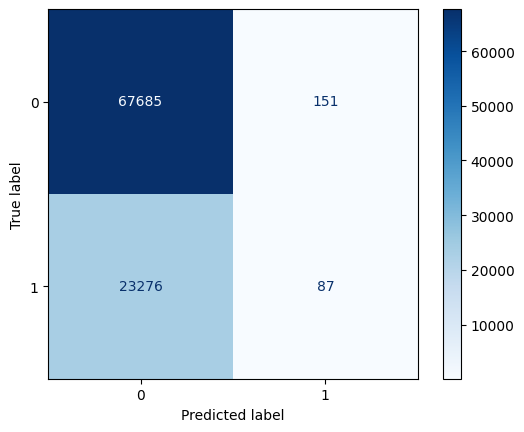


=== VALIDATION ===
accuarcy: 0.7364912280701754
Precision: 0.5
Recall: 0.004660452729693742
AUC: 0.5014964960170623


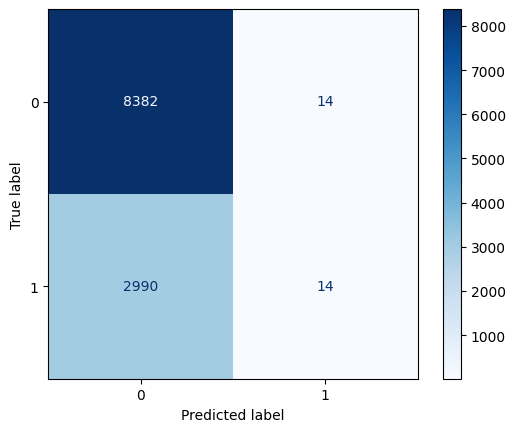


=== TEST ===
accuarcy: 0.7363157894736843
Precision: 0.39285714285714285
Recall: 0.0036666666666666666
AUC: 0.5008214285714285


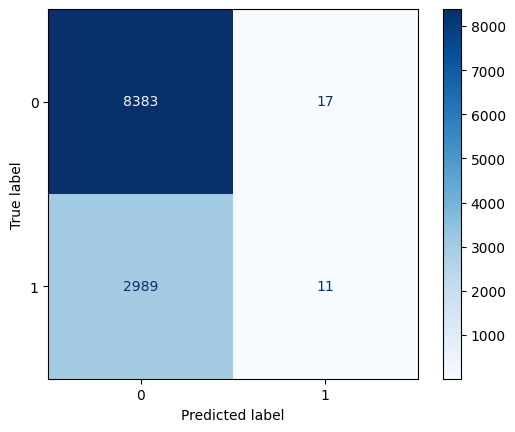

In [26]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train_scaled, y_train)
evaluate_classification(logistic_model, X_train_scaled, y_train, threshold=0.5)
evaluate_classification(logistic_model, X_valid_scaled, y_valid, "validation", threshold=0.5)
evaluate_classification(logistic_model, X_test_scaled, y_test, "test", threshold=0.5)

#### XGBoost

In [ ]:
xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss"
)
params_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 10, None],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'gamma': [0, 1, 5],
    'reg_lambda': [0.1, 1, 5, 10],
    'reg_alpha': [0, 0.1, 1]
}

grid= RandomizedSearchCV(
    xgb_model,
    params_grid,
    n_iter=30,
    cv=3,
    scoring= "accuracy",
    n_jobs=1,
    verbose = 2,
    random_state = 0
)

grid.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.5, gamma=1, learning_rate=0.01, max_depth=20, n_estimators=400, reg_alpha=1, reg_lambda=5, subsample=1.0; total time=   6.1s
[CV] END colsample_bytree=0.5, gamma=1, learning_rate=0.01, max_depth=20, n_estimators=400, reg_alpha=1, reg_lambda=5, subsample=1.0; total time=   5.6s
[CV] END colsample_bytree=0.5, gamma=1, learning_rate=0.01, max_depth=20, n_estimators=400, reg_alpha=1, reg_lambda=5, subsample=1.0; total time=   5.7s
[CV] END colsample_bytree=0.7, gamma=1, learning_rate=0.1, max_depth=20, n_estimators=400, reg_alpha=1, reg_lambda=10, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.7, gamma=1, learning_rate=0.1, max_depth=20, n_estimators=400, reg_alpha=1, reg_lambda=10, subsample=1.0; total time=   1.2s
[CV] END colsample_bytree=0.7, gamma=1, learning_rate=0.1, max_depth=20, n_estimators=400, reg_alpha=1, reg_lambda=10, subsample=1.0; total time=   1.3s
[CV] END colsample_by

,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.5, 0.7, ...], 'gamma': [0, 1, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [5, 10, ...], ...}"
,n_iter,30
,scoring,'accuracy'
,n_jobs,1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,0
,error_score,nan



=== TRAIN ===
accuarcy: 0.9257667298983542
Precision: 0.9771668487950768
Recall: 0.7272182510807688
AUC: 0.8606829506479968


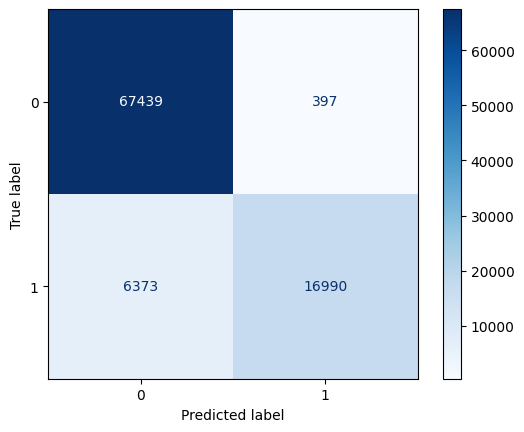


=== VALIDATION ===
accuarcy: 0.8051754385964912
Precision: 0.7547169811320755
Recall: 0.38615179760319573
AUC: 0.6706247315791111


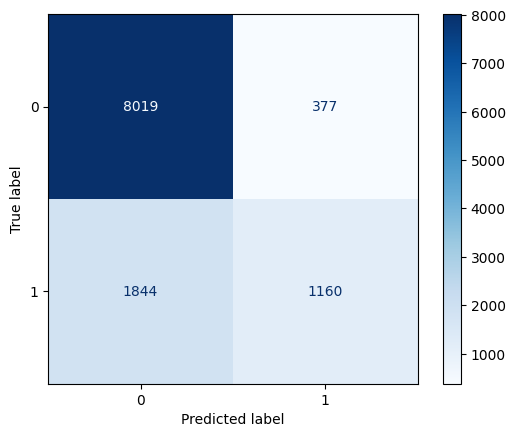


=== TEST ===
accuarcy: 0.8028947368421052
Precision: 0.7591190640055059
Recall: 0.36766666666666664
AUC: 0.663


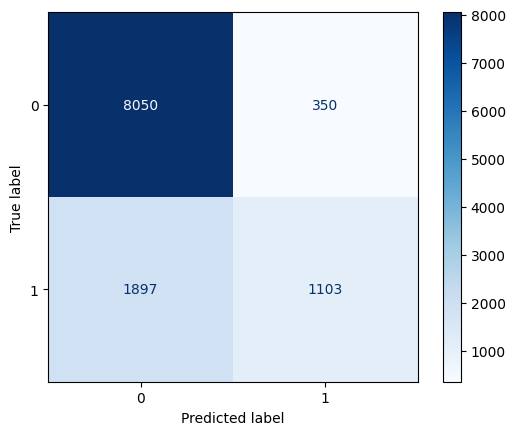

In [54]:
best_xgb = grid.best_estimator_
xgb_model.fit(X_train, y_train)
evaluate_classification(best_xgb, X_train, y_train, "train", threshold=0.5)
evaluate_classification(best_xgb, X_valid, y_valid, "Validation", threshold=0.5)
evaluate_classification(best_xgb, X_test, y_test, "Test", threshold=0.5)

#### Using XGBoost to get important features

In [48]:
importances = pd.Series(best_xgb.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False)

explicit          0.250011
acousticness      0.082398
time_signature    0.079002
liveness          0.078567
valence           0.077626
danceability      0.076678
loudness          0.075164
speechiness       0.073460
energy            0.073325
tempo             0.072023
key               0.061746
dtype: float32

#### Random Forest

##### Using GridSearch for best parameters

In [ ]:
rf_model = RandomForestClassifier()

params_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 20, 30, None],
    'min_samples_split': [2, 5, 10, 20],
    'class_weight': [None, 'balanced']
}

grid_rf= RandomizedSearchCV(
    rf_model,
    params_grid,
    n_iter=30,
    cv=3,
    scoring= "accuracy",
    n_jobs=1,
    verbose = 2,
    random_state = 0
)

grid_rf.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END class_weight=balanced, max_depth=10, min_samples_split=20, n_estimators=300; total time=  25.0s
[CV] END class_weight=balanced, max_depth=10, min_samples_split=20, n_estimators=300; total time=  24.7s
[CV] END class_weight=balanced, max_depth=10, min_samples_split=20, n_estimators=300; total time=  26.2s
[CV] END class_weight=balanced, max_depth=20, min_samples_split=2, n_estimators=100; total time=  15.2s
[CV] END class_weight=balanced, max_depth=20, min_samples_split=2, n_estimators=100; total time=  14.4s
[CV] END class_weight=balanced, max_depth=20, min_samples_split=2, n_estimators=100; total time=  13.7s
[CV] END class_weight=balanced, max_depth=30, min_samples_split=20, n_estimators=400; total time= 1.0min
[CV] END class_weight=balanced, max_depth=30, min_samples_split=20, n_estimators=400; total time= 1.0min
[CV] END class_weight=balanced, max_depth=30, min_samples_split=20, n_estimators=400; total time= 1.0m

,estimator,RandomForestClassifier()
,param_distributions,"{'class_weight': [None, 'balanced'], 'max_depth': [5, 10, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 200, ...]}"
,n_iter,30
,scoring,'accuracy'
,n_jobs,1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,0
,error_score,nan


Do RandomForestClassifier with the given parameters


=== TRAIN ===
accuarcy: 0.9927630785425279
Precision: 0.9953742090333842
Recall: 0.976287291871763
AUC: 0.9873623498688965


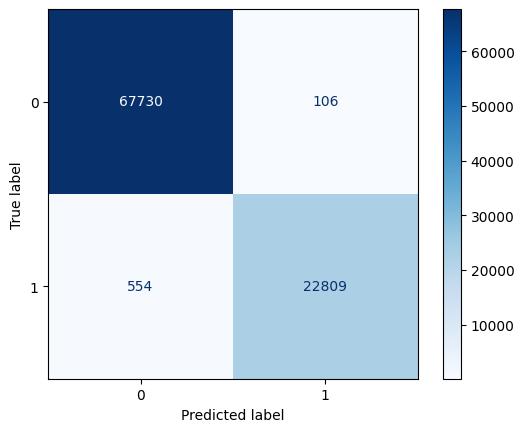


=== VALID ===
accuarcy: 0.847280701754386
Precision: 0.8939488459139114
Recall: 0.4770306258322237
AUC: 0.7283914444072981


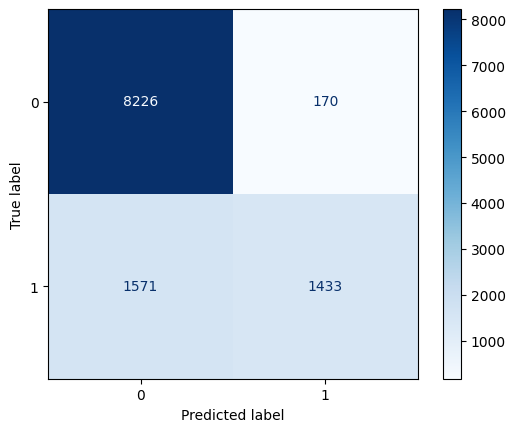


=== TEST ===
accuarcy: 0.8399122807017544
Precision: 0.8935030140656397
Recall: 0.44466666666666665
AUC: 0.7128690476190476


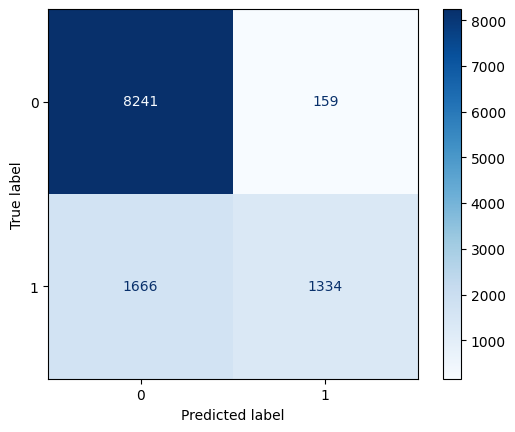

0.8399122807017544


In [50]:
best_rf = grid_rf.best_estimator_
evaluate_classification(best_rf, X_train, y_train, "train", threshold = 0.5)
evaluate_classification(best_rf, X_valid, y_valid, "valid", threshold = 0.5)
evaluate_classification(best_rf, X_test,  y_test,  "test", threshold = 0.5)
print(best_rf.score(X_test, y_test))

#### Using Random Forest to get important features

In [49]:
importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False)

explicit          0.250011
acousticness      0.082398
time_signature    0.079002
liveness          0.078567
valence           0.077626
danceability      0.076678
loudness          0.075164
speechiness       0.073460
energy            0.073325
tempo             0.072023
key               0.061746
dtype: float32

#### Cross validation to see if we are overfitting

In [330]:
scores = cross_val_score(
    rf_model, 
    X_train,    
    y_train, 
    cv=20,
    scoring='f1'
)
print("Cross-validation scores:", scores)
print("Mean CV score:", scores.mean())
print("Standard deviation:", scores.std())


Cross-validation scores: [0.60224719 0.60368921 0.56206897 0.62249443 0.63316583 0.592719
 0.61401557 0.60533788 0.59728507 0.59382151 0.59438202 0.59671015
 0.61135857 0.60312152 0.58776897 0.60136674 0.59797297 0.59629422
 0.59196378 0.59498607]
Mean CV score: 0.6001384838327997
Standard deviation: 0.0138323395448769


## Model Evaluation